# Run Morphodynamics programmatically

The package napari-morphodynamics offers a way to use MorphoDynamics interactively. However sometimes it is easier to run the analysis purely via code, especially when automating tasks. We show here an example how to do this.

In [1]:
%load_ext autoreload
%autoreload 2

## Data and folders

We use here a public time-lase dataset (Mahlandt, E. K., Arts, J. J. G., & Goedhart, J. (2021). Example data from timelapse fluorescence imaging experiments (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4501412) where a cell is shrinking.

As a first step we load the data (here from Zenodo, but usually locally):

In [2]:
import skimage
from microfilm.microplot import microshow

In [3]:
im = skimage.io.imread('https://zenodo.org/records/4501412/files/2010230_BOEC-mTq2-CaaX.tif?download=1')

Then we create the folders in which we will save the data and the analysis:

In [ ]:
data_folder = 'cellsize/'
analysis_folder = 'cellsize/analysis/'
segmentation_folder = 'cellsize/analysis/cellposeseg/'

In [5]:
import os
os.makedirs(data_folder, exist_ok=True)
os.makedirs(analysis_folder, exist_ok=True)
os.makedirs(segmentation_folder, exist_ok=True)
skimage.io.imsave('cellsize/cellsize.tif', im, check_contrast=False)

## Param object

Now we need to create the object that contains all the information about our analysis. This is done with the ```parameters``` submodule. The Param object will contain the path to the data, the channels to use, the path to the export, the segmentation settings etc.

We specify here first the segmentation and signal channels. As we only have a single channel these are the same. Note however that we still enclose the signal channel in brackets as it could be a list:

In [7]:
morpho_name = 'cellsize.tif'
signal_name = ['cellsize.tif']

Now we can finally create our parameter object. As additional information, we indicate that we have a multipage tiff file and that the cell has a diameter of ~250 pixels (for cellpose segmentation later):

In [11]:
from morphodynamics.store.parameters import Param
param = Param(
    data_type='multi',
    data_folder=data_folder,
    analysis_folder=analysis_folder,
    seg_folder=segmentation_folder,
    morpho_name=morpho_name,
    signal_name=signal_name,
    diameter=250)

Now we can load our data via the parameter object. We could also directly create a data object but this ensures that all the information is consistent. For this we use the ```load_alldata``` function that can take ```param``` as an input and use its info to initialize the ```data``` object.

In [12]:
from morphodynamics.utils import load_alldata

In [13]:
param, _, data = load_alldata(folder_path=None, param=param)

To check that everything works, we can load some frames from the data and display them:

In [15]:
im = data.load_frame_morpho(0)
im2 = data.load_frame_morpho(66)

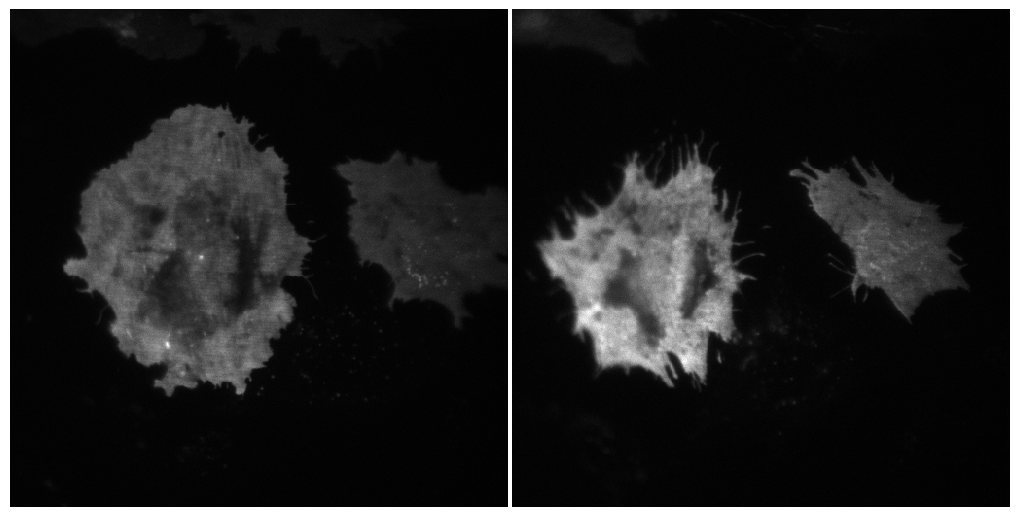

In [16]:
from microfilm.microplot import Micropanel
panel = Micropanel(1,2)
panel.add_element(pos=[0,0], microim=microshow(im, ax=panel.ax[0,0]))
panel.add_element(pos=[0,1], microim=microshow(im2, ax=panel.ax[0,1]));

## Analysis

For the analysis we can optionally exploit all the available computing cores by using Dask. Below you can see an example on how to setup a Dask client for this.

In [ ]:
"""
from dask.distributed import Client, LocalCluster
cluster  = LocalCluster()
cluster.scale(1)
client = Client(cluster)
"""

client = None

The first task is to segment the images and track the cell between frames. Here we use the built-in cellpose segmentation but you could also segment your images using your favorite method. You would still need to run the ```segment_and_track``` function to make sure the cell is properly tracked (e.g. if you have more than one object in the field of view).

In [20]:
from morphodynamics.analysis_par import segment_and_track

The segmentation and tracking function simply takes ```data``` and ```param``` as main input:

In [ ]:
res, segmented = segment_and_track(data=data, param=param, client=client)

The next step is the windowing of the masks. We can set first some options such as the windows' dimensions again in the ```param``` object:

In [23]:
param.width = 10
param.depth = 10

Now we can run the windowing, which takes the same inputs as the segmentation:

In [19]:
from morphodynamics.analysis_par import spline_and_window

In [24]:
res = spline_and_window(data=data, param=param, res=res, client=client)

frames compute windows:   0%|                                                                       | 0/67 [00:00<?, ?it/s]/Users/gw18g940/GoogleDrive/BernMIC/Projects/MorphoDynamics/morphodynamics/analysis_par.py:457: RuntimeWarning: invalid value encountered in cast
  skimage.io.imsave(name2, b0.astype(np.uint8), check_contrast=False)
frames compute mapping: 100%|██████████████████████████████████████████████████████████████| 66/66 [03:05<00:00,  2.81s/it]


At this point the analysis is finished. However none of the information has been saved yet. We can do that now using the ```export_results_parameters``` function:

In [26]:
from morphodynamics.utils import export_results_parameters

In [27]:
export_results_parameters(param=param, res=res)

We can verify whether the analyis was successful, e.g. by plotting the area over time:

In [28]:
from morphodynamics.plots import show_plots

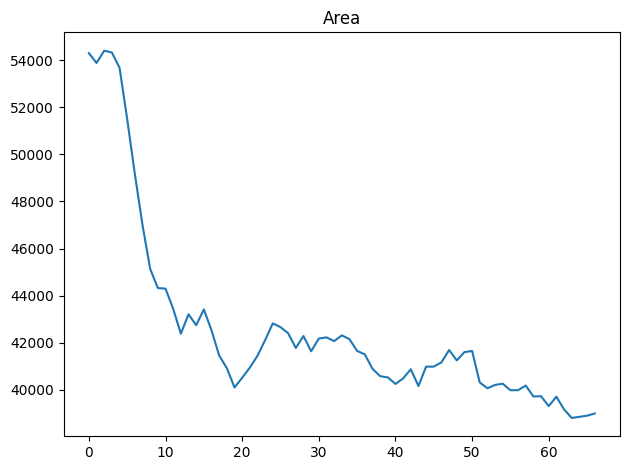

In [30]:
show_plots.show_geometry(data=data, res=res, prop='area');

As expected, the cell undergoes a marked reduction in size. For more details on plotting outputs, please see the [Morphoplotting](https://guiwitz.github.io/MorphoDynamics/mydocs/Morphoplotting.html) chapter.